# Studying Solvers performance: Jacobi vs Gauss-Seidel vs Conjugate Gradient in 2D
April 2, 2022
Venkitesh Ayyar

In [60]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from IPython.display import clear_output



In [61]:
%matplotlib widget

## 2D

In [62]:
L=8; max_iters=1000;m=0.5;
N=L**2
scale=4.0+m**2.0 ## Diagonal value

In [63]:
A=np.zeros((N,N),dtype=np.float64)
b=np.zeros(N,dtype=np.float64)
b[L//2-1 + L * (L//2-1)]=1.0

In [64]:
# Generate Laplace matrix
for x in range(L):
    for y in range(L):
        idx=x+y*L
        A[idx,idx]=scale
        A[idx,(x-1+L)%L+y*L]=-1.0
        A[idx,(x+1)%L+y*L]=-1.0
        A[idx,x+((y-1+L)%L)*L]=-1.0
        A[idx,x+((y+1+L)%L)*L]=-1.0

In [65]:
np.linalg.det(A)

3.8147058115267065e+35

In [66]:
## Solving correctly using inverse
a_inv=np.linalg.inv(A)
x_exact=np.dot(a_inv,b)
# print("Actual solution from inversion",x_exact)

## Check if solution is correct
print("\nIs residue zero? ",np.allclose(np.dot(A,x_exact),b))


Is residue zero?  True


### Jacobi method
A = D + (L + U)

$ x^{k+1} = D ^{-1} \left( \mathbf{b} - (L + U) \mathbf{x} ^{k} \right)  $ 

$$ x_{i}^{k+1} = \frac{1}{A_{ii}} \left( b_i - \sum_{j=1; j \neq i}^{N} A_{ij} x^{k}_j \right) $$

In [67]:
def f_jacobi_generic(A,arr_x,b,max_iters):
    ''' Performing Jacobi Iterations'''
    x      = arr_x[0,:].copy()  # Solution array
    x_temp = x.copy()  # Temp array required for Jacobi
    
    res=b-np.dot(A,x)
    
    for k in range(1,max_iters):
        for i in range(N):
            tsum=0.0
            for j in range(N):
                if j!=i:  tsum+=A[i,j]*x[j]
                
            # Store in temp array until all are updated.
            x_temp[i]=(b[i]-tsum) * (1.0/(A[i,i]+1e-15))    
            
        x=x_temp.copy()
        arr_x[k]=x.copy() # Store value at iteration

        res=b-np.dot(A,x)
        if np.allclose(res,np.zeros(N),rtol=1e-5,atol=1e-12):
            print("Quitting after {0} iterations".format(k))
            break
        if (k==max_iters-1): print("No convergence after % iterations"%(max_iters))


    arr_x=arr_x[:k+1,:]
    return arr_x



def f_get_residue(b,x,diag):
    
    res=np.zeros_like(b)
    for i in range(N):
        x1=i%L
        y1=i//L
        res[i]=b[i]- x[i] * diag + x[(x1-1+L)%L+y1*L] + x[(x1+1)%L+y1*L] + x[x1+((y1-1+L)%L)*L] + x[x1+((y1+1)%L)*L]
    
    return res


def f_jacobi(arr_x,b,diag,max_iters):
    ''' Performing Jacobi Iterations for Laplace operator'''
    x      = arr_x[0,:].copy()  # Solution array
    x_temp = x.copy()  # Temp array required for Jacobi
    
    # Residue
    res=f_get_residue(b,x,diag)
    
    for k in range(1,max_iters):
        for i in range(N):
            # Store in temp array until all are updated.
            
            x1=i%L
            y1=i//L
            # x_temp[i]=(b[i]+ x[(i-1+N)%N] + x[(i+1)%N])* (1.0/diag)
            x_temp[i]=(b[i]+ x[(x1-1+L)%L+y1*L] + x[(x1+1)%L+y1*L] + x[x1+((y1-1+L)%L)*L] + x[x1+((y1+1)%L)*L])* (1.0/diag)
            
        x=x_temp.copy()
        arr_x[k]=x.copy()

        res=f_get_residue(b,x,diag)
        
        if np.allclose(res,np.zeros(N),rtol=1e-5,atol=1e-12):
            print("Quitting after {0} iterations".format(k))
            break
        if (k==max_iters-1): print("No convergence after % iterations"%(max_iters))

    arr_x=arr_x[:k+1,:]


    return arr_x


In [68]:
max_iters=2000
x_jc=np.ones((max_iters,N),dtype=np.float64)*0.0
# x_jc=f_jacobi_generic(A,x_jc,b,max_iters)
x_jc=f_jacobi(x_jc,b,scale,max_iters)

np.allclose(x_jc[-1],x_exact)

Quitting after 399 iterations


True

## Gauss-Seidel method

$$ x_{i}^{k+1} = \frac{1}{A_{ii}} \left( b_i - \sum_j^{i-1} A_{ij} x^{k+1}_j - \sum_{j=i+1}^n A_{ij} x_j^k \right) $$


In [69]:
def f_gauss_seidel_generic(A,arr_x,b,max_iters):
    ''' Performing Gauss_seidel Iterations'''

    x=arr_x[0,:].copy() # Solution array. We're storing all solutions, so we copy this to an array.
    
    res=b-np.dot(A,x)
    
    for k in range(1,max_iters):
        for i in range(N):
            tsum=0.0
            for j in range(N):
                ## Just using the updated array is sufficient. Don't need two conditions: j<i , j<i
                if j!=i:  tsum+=A[i,j]*x[j] 
                
            x[i]=(b[i]-tsum) * 1.0/(A[i,i]+1e-15)
            
        arr_x[k]=x.copy()
        
        res=b-np.dot(A,x)
        if np.allclose(res,np.zeros(N),rtol=1e-5,atol=1e-12):
            print("Quitting after {0} iterations".format(k))
            break
        if (k==max_iters-1): print("No convergence after % iterations"%(max_iters))

    arr_x=arr_x[:k+1,:]
    return arr_x


def f_get_residue(b,x,diag):
    
    res=np.zeros_like(b)
    for i in range(N):
        x1=i%L
        y1=i//L
        res[i]=b[i]- x[i] * diag + x[(x1-1+L)%L+y1*L] + x[(x1+1)%L+y1*L] + x[x1+((y1-1+L)%L)*L] + x[x1+((y1+1)%L)*L]

    return res

def f_gauss_seidel(arr_x,b,diag,max_iters):
    ''' Performing Gauss_seidel Iterations for Laplace operator'''
    x=arr_x[0,:].copy() # Solution array. We're storing all solutions, so we copy this to an array.
    
    # Residue
    res=f_get_residue(b,x,diag)

    for k in range(1,max_iters):
        for i in range(N):
            x1=i%L
            y1=i//L
            x[i]=(b[i]+ x[(x1-1+L)%L+y1*L] + x[(x1+1)%L+y1*L] + x[x1+((y1-1+L)%L)*L] + x[x1+((y1+1)%L)*L])* (1.0/diag)
            
        arr_x[k]=x.copy()
        res=f_get_residue(b,x,diag)
        
        if np.allclose(res,np.zeros(N),rtol=1e-5,atol=1e-12):
            print("Quitting after {0} iterations".format(k))
            break
        if (k==max_iters-1): print("No convergence after % iterations"%(max_iters))

    arr_x=arr_x[:k+1,:]
    return arr_x


In [70]:
max_iters=2000
x_gs=np.ones((max_iters,N),dtype=np.float64)*0.0
# x_gs=f_gauss_seidel_generic(A,x_gs,b,max_iters)
x_gs=f_gauss_seidel(x_gs,b,scale,max_iters)

np.allclose(x_gs[-1],x_exact)



Quitting after 204 iterations


True

## Conjugate gradient

$$ \alpha_k = \frac{r_k^T r_k}{p_k ^ T A p_k} $$

$$ \beta_k = \frac{r_{k+1}^T A p_k}{p_k^T A p_k} $$

$$ x_{k+1} = x_k + \alpha_k p_k $$ 

$$ r_{k+1} = r_k - \alpha_k A p_k $$

$$ p_{k+1} = r_{k+1} + \beta_k p_k $$

In [71]:

# def f_cg_generic(A,arr_x,b,max_iters):

#     x_old=arr_x[0,:].copy()
#     r_old=b-np.dot(A,x_old)
#     p_old=r_old.copy()
    
#     for k in range(1,max_iters):    

#         alpha=np.dot(r_old,r_old)/np.dot(p_old,np.dot(A,p_old))
#         x_new=x_old+alpha*p_old
#         r_new=r_old-alpha*np.dot(A,p_old)

#         beta=np.dot(r_new,r_new)/np.dot(r_old,r_old)

#         p_new= r_new + beta * p_old

#         arr_x[k,:]=x_new.copy()
#         x_old=x_new.copy()
#         r_old=r_new.copy()
#         p_old=p_new.copy()

#         if np.allclose(r_new,np.zeros(N**2),rtol=1e-5,atol=1e-12):
#             print("Quitting after {0} iterations".format(k))
#             break

#     arr_x=arr_x[:k+1,:]
    
#     return arr_x


def f_cg_generic(A,arr_x,b,max_iters):

    x=arr_x[0,:].copy()
    r_old=b-np.dot(A,x)
    p=r_old.copy()
    
    for k in range(1,max_iters):    
        Ap=np.dot(A,p)
        
        rsquare=np.dot(r_old,r_old)
        alpha=rsquare/np.dot(p,Ap)
        x+=alpha*p
        r_new=r_old-alpha*Ap

        beta=np.dot(r_new,r_new)/rsquare

        p= r_new + beta * p

        arr_x[k,:]=x.copy()
        r_old=r_new.copy()
        # p_old=p_new.copy()

        if np.allclose(r_new,np.zeros(N),rtol=1e-5,atol=1e-12):
            print("Quitting after {0} iterations".format(k))
            break
        if (k==max_iters-1): print("No convergence after % iterations"%(max_iters))
    
    arr_x=arr_x[:k+1,:]
    
    return arr_x


def f_get_residue(b,x,diag):
    
    res=np.zeros_like(b)
    for i in range(N):
        x1=i%L
        y1=i//L
        res[i]=b[i]- x[i] * diag + x[(x1-1+L)%L+y1*L] + x[(x1+1)%L+y1*L] + x[x1+((y1-1+L)%L)*L] + x[x1+((y1+1)%L)*L]

    return res

def f_cg(arr_x,b,diag,max_iters):

    x=arr_x[0,:].copy()
    r_old=f_get_residue(b,x,diag)
    p=r_old.copy()
    
    Ap=np.zeros_like(b)

    for k in range(1,max_iters):    

        for i in range(N): 
            x1=i%L
            y1=i//L            
            Ap[i]=(p[x1+y1*L]*diag - p[(x1-1+L)%L+y1*L] - p[(x1+1)%L+y1*L] - p[x1+((y1-1+L)%L)*L] - p[x1+((y1+1)%L)*L])

        rsquare=np.dot(r_old,r_old)
        alpha=rsquare/np.dot(p,Ap)
        x+=alpha*p  # Update solution
        r_new=r_old-alpha*Ap  # Update residue

        beta=np.dot(r_new,r_new)/rsquare

        p= r_new + beta * p

        arr_x[k,:]=x.copy()
        r_old=r_new.copy()

        if np.allclose(r_new,np.zeros(N),rtol=1e-5,atol=1e-12):
            print("Quitting after {0} iterations".format(k))
            break
        if (k==max_iters-1): print("No convergence after % iterations"%(max_iters))


    arr_x=arr_x[:k+1,:]
    
    return arr_x


In [72]:
max_iters=2000
x_cg=np.ones((max_iters,N),dtype=np.float64)*0.0
# x_cg=f_cg_generic(A,x_gs,b,max_iters)
x_cg=f_cg(x_gs,b,scale,max_iters)

np.allclose(x_cg[-1],x_exact)

Quitting after 13 iterations


True

In [73]:
x_cg[-1]

array([0.03128899, 0.03740477, 0.04534937, 0.05015236, 0.04534937,
       0.03740477, 0.03128899, 0.02908433, 0.03740477, 0.04867499,
       0.06602957, 0.08042506, 0.06602957, 0.04867499, 0.03740477,
       0.03365693, 0.04534937, 0.06602957, 0.10617628, 0.15959501,
       0.10617628, 0.06602957, 0.04534937, 0.0391481 , 0.05015236,
       0.08042506, 0.15959501, 0.38550119, 0.15959501, 0.08042506,
       0.05015236, 0.04202374, 0.04534937, 0.06602957, 0.10617628,
       0.15959501, 0.10617628, 0.06602957, 0.04534937, 0.0391481 ,
       0.03740477, 0.04867499, 0.06602957, 0.08042506, 0.06602957,
       0.04867499, 0.03740477, 0.03365693, 0.03128899, 0.03740477,
       0.04534937, 0.05015236, 0.04534937, 0.03740477, 0.03128899,
       0.02908433, 0.02908433, 0.03365693, 0.0391481 , 0.04202374,
       0.0391481 , 0.03365693, 0.02908433, 0.02737348])

### Plot  

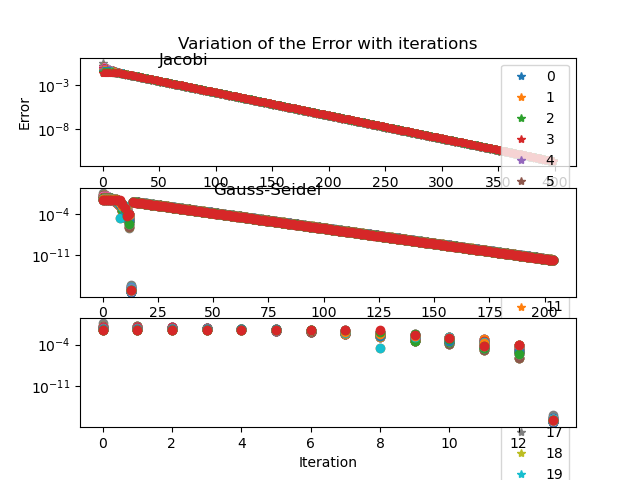

In [74]:
fig=plt.figure()

# Jacobi
arr=x_jc[:]
fig.add_subplot(3,1,1)
plt.text(50,0.2,"Jacobi",fontsize=12)
for idx in range(arr.shape[1]):
    y=np.abs(arr[:,idx]-np.ones(arr.shape[0])*x_exact[idx])
    plt.plot(y,label=str(idx),marker='*',linestyle='')
plt.legend(loc='upper right')
plt.title("Variation of the Error with iterations")
plt.ylabel("Error")
plt.yscale('log')

# Gauss-Seidel
arr=x_gs[:]
fig.add_subplot(3,1,2)
for idx in range(arr.shape[1]):
    y=np.abs(arr[:,idx]-np.ones(arr.shape[0])*x_exact[idx])
    plt.plot(y,label=str(idx),linestyle='',marker='o')
plt.text(50,0.2,"Gauss-Seidel",fontsize=12)
plt.xlabel("Iteration")
plt.yscale('log')

# Conjugate gradient
arr=x_cg[:]
fig.add_subplot(3,1,3)
for idx in range(arr.shape[1]):
    y=np.abs(arr[:,idx]-np.ones(arr.shape[0])*x_exact[idx])
    plt.plot(y,label=str(idx),linestyle='',marker='o')
plt.text(50,0.2,"CG",fontsize=12)
plt.xlabel("Iteration")
plt.yscale('log')

plt.show()


In [75]:
# # Difference between GS and Jacobi
# plt.figure()
# plt.title("Difference between GS and Jacobi")
# num_iters=min(x_gs.shape[0],x_jc.shape[0])

# for idx in range(N):
#     y=x_gs[:num_iters,idx]-x_jc[:num_iters,idx]
#     plt.plot(y,label=str(idx),marker='*',linestyle='')
# plt.xlabel("Iteration")

(64,)
(64,)
(64,)


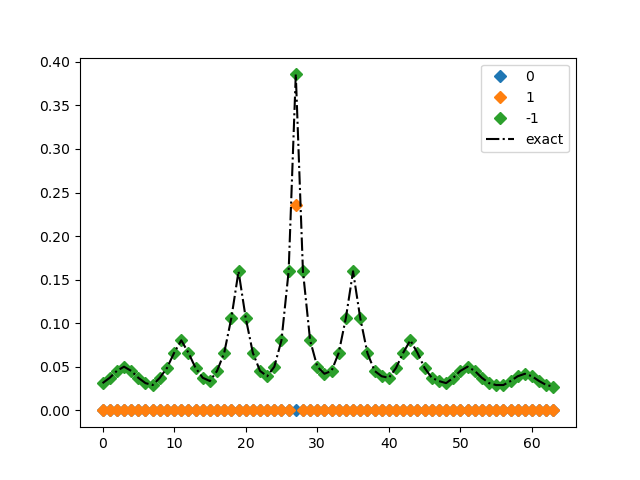

In [88]:
iter_list=[0,1,-1]
# iter_list=[0,50,100,200,300,400,499]
arr=x_cg
plt.figure()
for itr in iter_list:
    y=arr[itr,:]
    print(y.shape)
    plt.plot(y,label=str(itr),linestyle='',marker='D')
plt.plot(x_exact,linestyle='-.',color='k',label='exact')
plt.legend(loc='best')


In [87]:
x_exact

array([0.03128899, 0.03740477, 0.04534937, 0.05015236, 0.04534937,
       0.03740477, 0.03128899, 0.02908433, 0.03740477, 0.04867499,
       0.06602957, 0.08042506, 0.06602957, 0.04867499, 0.03740477,
       0.03365693, 0.04534937, 0.06602957, 0.10617628, 0.15959501,
       0.10617628, 0.06602957, 0.04534937, 0.0391481 , 0.05015236,
       0.08042506, 0.15959501, 0.38550119, 0.15959501, 0.08042506,
       0.05015236, 0.04202374, 0.04534937, 0.06602957, 0.10617628,
       0.15959501, 0.10617628, 0.06602957, 0.04534937, 0.0391481 ,
       0.03740477, 0.04867499, 0.06602957, 0.08042506, 0.06602957,
       0.04867499, 0.03740477, 0.03365693, 0.03128899, 0.03740477,
       0.04534937, 0.05015236, 0.04534937, 0.03740477, 0.03128899,
       0.02908433, 0.02908433, 0.03365693, 0.0391481 , 0.04202374,
       0.0391481 , 0.03365693, 0.02908433, 0.02737348])

In [77]:
def f_get_2d_image(arr):
    img_arr=np.zeros((L,L),dtype=np.float64)
    for x in range(L):
        for y in range(L):
            img_arr[x,y]=arr[x+y*L]
    
    return img_arr

img_arr=f_get_2d_image(x_cg[-1])

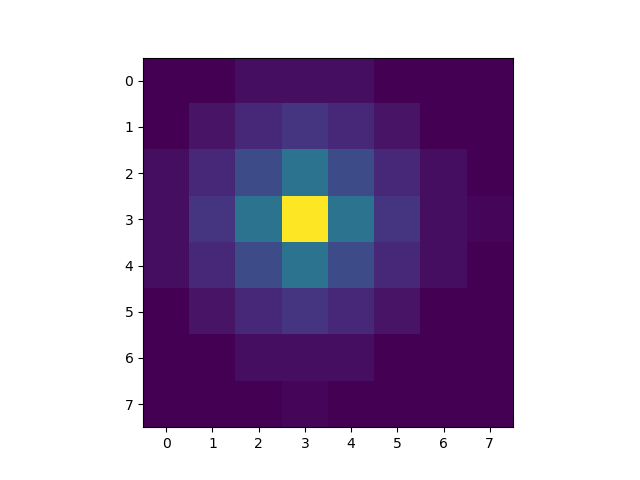

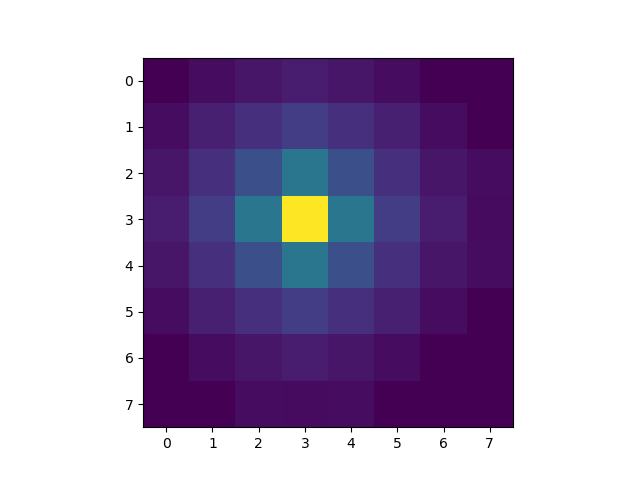

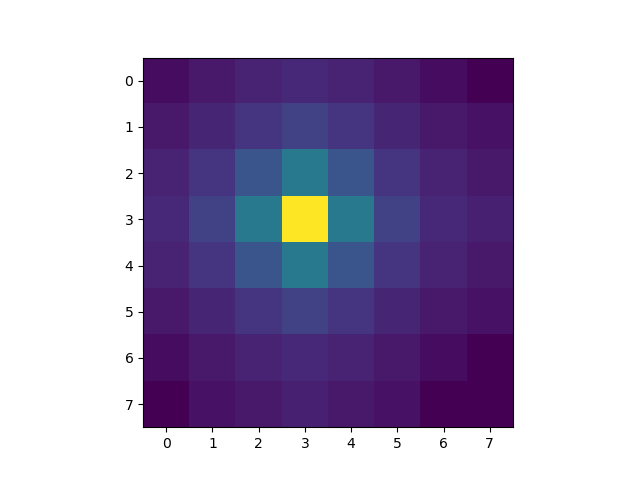

In [78]:
plt.figure()
arr=x_cg[:]

for i in range(5,8):    
    img_arr=f_get_2d_image(arr[i])
    plt.imshow(img_arr)
    # plt.title("Iteration",i)
    plt.show()

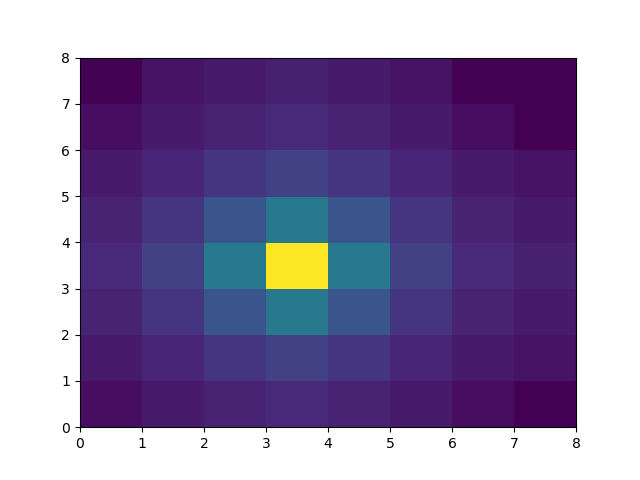

In [22]:
plt.figure()
plt.pcolor(img_arr)